In [1]:
# Input:
path_x_train = '/content/X_train.npy'
path_y_train = '/content/y_train.npy'
path_x_val = '/content/X_val.npy'
path_y_val = '/content/y_val.npy'
path_scaler = '/content/time_scaler.pickle'
epochs=50
metrics = ['mae']
batch_size=500
model_name='forecaste_lstm.hdf5'
monitor='val_mae'
mode='min'
patience=5
test_score, val_score = 'mae', 'val_mae'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pickle
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [3]:
# Load data
X_train = np.load(open(path_x_train, 'rb'))
y_train = np.load(open(path_y_train, 'rb'))
X_val = np.load(open(path_x_val, 'rb'))
y_val = np.load(open(path_y_val, 'rb'))

In [4]:
# LSTM architecture
def build_lstm_model(X_train):
    model = Sequential()
    model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(16, activation='relu'))
    model.add(Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return model

In [5]:
# Set callbacks
def create_callbacks(model_name, monitor, mode, patience):
    # Early stopping
    es = EarlyStopping(
        monitor=monitor, mode=mode, verbose=0, patience=patience, restore_best_weights=True
    )

    # Checkpoint
    checkpoint = ModelCheckpoint(
        filepath=model_name,
        monitor=monitor,
        mode=mode,
        save_best_only=True
    )

    return es, checkpoint

In [6]:
# Fit model
def fit_model(model, es, checkpoint):
    model_history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, es],
        shuffle=False,
        verbose=2
    )
    return model, model_history

In [7]:
# Plot model history
def plot_history(model_history, test_score, val_score):
    # Visualize the CNN training history
    fig, ax = plt.subplots(1, 2, figsize=(6,2))

    # Accuracy
    ax[0].plot(model_history.history[test_score])
    ax[0].plot(model_history.history[val_score])
    ax[0].set_title(test_score)
    ax[0].set_ylabel(test_score)
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    # Loss
    ax[1].plot(model_history.history['loss'])
    ax[1].plot(model_history.history['val_loss'])
    ax[1].set_title('loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.show()

In [14]:
# Create callbacks
es, checkpoint = create_callbacks('forecaster_lstm.hdf5', monitor, mode, patience)
# Build model architecture
model_lstm = build_lstm_model(X_train)
# Fit the model
model_lstm, model_lstm_history = fit_model(model_lstm, es, checkpoint)

Epoch 1/50
10/10 - 4s - loss: 0.9707 - mae: 0.7636 - val_loss: 1.8460 - val_mae: 1.0151 - 4s/epoch - 359ms/step
Epoch 2/50
10/10 - 0s - loss: 0.9019 - mae: 0.7354 - val_loss: 1.5211 - val_mae: 0.9295 - 198ms/epoch - 20ms/step
Epoch 3/50
10/10 - 0s - loss: 0.8372 - mae: 0.7126 - val_loss: 1.2514 - val_mae: 0.8571 - 178ms/epoch - 18ms/step
Epoch 4/50
10/10 - 0s - loss: 0.7898 - mae: 0.6974 - val_loss: 1.1898 - val_mae: 0.8337 - 186ms/epoch - 19ms/step
Epoch 5/50
10/10 - 0s - loss: 0.7398 - mae: 0.6636 - val_loss: 1.1676 - val_mae: 0.8103 - 179ms/epoch - 18ms/step
Epoch 6/50
10/10 - 0s - loss: 0.6830 - mae: 0.6167 - val_loss: 1.0732 - val_mae: 0.7621 - 184ms/epoch - 18ms/step
Epoch 7/50
10/10 - 0s - loss: 0.6368 - mae: 0.5733 - val_loss: 0.9514 - val_mae: 0.7178 - 193ms/epoch - 19ms/step
Epoch 8/50
10/10 - 0s - loss: 0.5931 - mae: 0.5548 - val_loss: 0.8438 - val_mae: 0.6733 - 193ms/epoch - 19ms/step
Epoch 9/50
10/10 - 0s - loss: 0.5343 - mae: 0.5318 - val_loss: 0.7997 - val_mae: 0.6512 - 

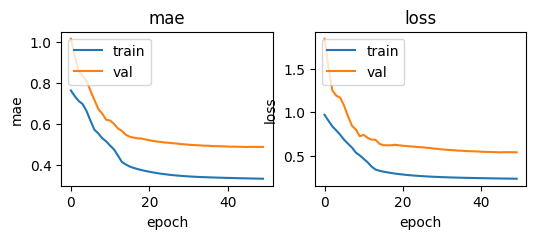

In [15]:
# Plot model history
plot_history(model_lstm_history, test_score, val_score)

# Invoke prediction

In [16]:
# Load model and tokenizer
loaded_model = load_model('/content/forecaster_lstm.hdf5')
scaler = pickle.load(open(path_scaler, 'rb'))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [32]:
def invert_transform_pred(pred, X_):
    # Invert the prediction scaling
    n_features = X_.shape[2]
    inv_X = X_.reshape((X_.shape[0], X_.shape[1] * X_.shape[2]))
    inv_X = np.concatenate((pred, inv_X[:, -n_features+1:]), axis=1)
    inv_X = scaler.inverse_transform(inv_X)
    inv_pred = inv_X[:,0]
    return inv_pred

In [33]:
# Forecast
pred_train = loaded_model.predict(X_train)
pred_train = invert_transform_pred(pred_train, X_train)
pred_train[:5]

145/145 [==============================] - 1s 4ms/step


array([2.18771356, 2.21906796, 1.45164605, 1.03344034, 1.04685421])

In [34]:
# Forecast
pred_val = loaded_model.predict(X_val)
invert_transform_pred(pred_val, X_val)
pred_val[:5]

34/34 [==============================] - 0s 7ms/step


array([[-0.04392144],
       [ 0.07865576],
       [ 0.01788398],
       [ 0.39381292],
       [ 0.30008128]], dtype=float32)

In [40]:
# Std of the true values
print(y_train.std())
print(y_val.std())

1.000192160348336
1.3698552164325488


In [37]:
# Evaluate the MAE
print(f'Train MAE: {round(mean_absolute_error(y_train, pred_train), 3)}')
print(f'Val MAE: {round(mean_absolute_error(y_val, pred_val), 3)}')

Train MAE: 1.828
Val MAE: 0.489


In [39]:
# Save
pd.DataFrame(pred_train).to_csv('pred_train.csv', index=False)
pd.DataFrame(pred_val).to_csv('pred_val.csv', index=False)